In [2]:
import pandas as pd
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
import os
os.chdir('..')

import main
import seaborn as sns
drive_path = r"W:\VEIDB/"
data_path = r"X:\Data"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [3]:
from datetime import date
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import os
import seaborn as sb
sb.set_style('white')

In [4]:
# Import local Neuron project
import sys
sys.path.append(os.path.abspath(r'C:\Users\bramn\Documents\NERF'))

import Neuron

In [5]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
raw_table_helper = ft.ephys_tables.EphysRawHelper()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()

In [6]:
def extract_timewindow(start, end, clusters_dict):
    matrix = np.zeros(shape=(len(clusters_dict), end-start)) # (neurons, time)
    cluster_idxs = np.zeros(shape=(len(clusters_dict)))
    for i, (c_idx, c_spiketimes) in enumerate(clusters_dict.items()):
        in_range = (c_spiketimes>=start) & (c_spiketimes<end)
        matrix[i][c_spiketimes[in_range]-start] = 1 # TODO: check
        cluster_idxs[i] = c_idx
    return matrix, cluster_idxs

In [140]:
exps, sesss = ['01588'], ['20211022']
# exps, sesss = ['01231'], ['20200327a']
# exps, sesss = ['01261'], ['20200327f']
# exps, sesss = ['01247'], ['20200328e']
window = [-240, 240]
figures_folder = os.path.join(r"C:\Users\bramn\Documents\NERF\DatajointVEIDB\images", f"optotagging_check_{exps[0]}_{sesss[0]}")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)
    
for exp, sess in zip(exps, sesss):
#     mean_waveforms = np.load(fr"X:\Data\{exp}\neuropixel\{sess}\sorted\mean_waveforms.npy")
#     mean_waveforms = np.load(r"Y:\Data\01247\M01\20200328e\sorted\000\mean_waveforms.npy")
    print(exp, sess)
    
    clusters, cluster_info = (subsess_spikes_table & {'experiment_id': exp, 'session_id': sess, 'subsession_id': 'OPTS_0014'}).fetch1('clusters', 'cluster_info')
    all_trials = (subsess_events_table & {'experiment_id': exp, 'session_id': sess, 'subsession_id': 'OPTS_0014'}).fetch1('trials')
    
    events = [t for trial in all_trials for t in trial[::2]] # Get event starts
    
    clusters_good = {c: spiketimes for c, spiketimes in clusters.items() if cluster_info['group'][c]=='good'}
    
    # Obtain spike matrices for each session (all pulses & all trials)
    spike_tensor = [] # (events, neurons, time)
    for event in events:
        matrix, cluster_idxs = extract_timewindow(event+window[0], event+window[1], clusters_good)
        spike_tensor.append(matrix)
    
    spike_tensor = np.stack(spike_tensor, axis=0)

01588 20211022


In [86]:
(raw_table & key).fetch1('ap_path', 'length')[0].split('\\')[1]

'OPTS_0014_g0_t0.imec.ap.bin'

In [128]:
(subsess_events_table & {'experiment_id': '01588', 'subsession_id': 'OPTS_0014'}).fetch1('trials')

[[2163063, 2163438],
 [2787066,
  2787342,
  2793066,
  2793343,
  2799066,
  2799343,
  2805067,
  2805341,
  2811067,
  2811339,
  2817067,
  2817338,
  2823067,
  2823337,
  2829067,
  2829339,
  2835067,
  2835336,
  2841067,
  2841338],
 [3447071,
  3447369,
  3453071,
  3453371,
  3459071,
  3459369,
  3465071,
  3465367,
  3471071,
  3471370,
  3477071,
  3477369,
  3483071,
  3483367,
  3489071,
  3489369,
  3495071,
  3495371,
  3501071,
  3501367],
 [5275984,
  5276315,
  5281984,
  5282313,
  5287985,
  5288312,
  5293985,
  5294311,
  5299985,
  5300311,
  5305985,
  5306312,
  5311985,
  5312312,
  5317985,
  5318310,
  5323985,
  5324311,
  5329985,
  5330312],
 [6595993,
  6596056,
  6601993,
  6602056,
  6607994,
  6608058,
  6613994,
  6614058,
  6619994,
  6620060,
  6625994,
  6626061,
  6631994,
  6632063,
  6637994,
  6638066,
  6643994,
  6644070,
  6649994,
  6650072],
 [7255998,
  7256281,
  7261998,
  7262279,
  7267998,
  7268286,
  7273998,
  7274286,
  72799

In [42]:
subsess_events_table & {'experiment_id': '01588'}

*experiment_id *mouse_id    *session_id    *subsession_id subsession_typ start_abs     trials     subsession trials_sti trials_sta trials_end
+------------+ +----------+ +------------+ +------------+ +------------+ +-----------+ +--------+ +--------+ +--------+ +--------+ +--------+
01588          M01          20211022       CHPE_0001      CHPE           0             =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
01588          M01          20211022       DIMM_0005      DIMM           29929908      =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
01588          M01          20211022       EXPA_0003      EXPA           16618680      =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
01588          M01          20211022       EXPB_0002      EXPB           9961236       =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
01588          M01          20211022       OPTS_0013      OPTS           109172856     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
01588          M01          20211022       OPTS_0014      OPTS           112603716     =BLOB=     =BLOB=     =BLOB=     =BLOB=     =BLOB=    
 (Total: 6)

In [41]:
exp_table

*experiment_id config_type    description    experimenters 
+------------+ +------------+ +------------+ +------------+
01230          Arnau          NTSR1-optotagg Arnau Sans Dub
01231          Arnau          NTSR1-optotagg Arnau Sans Dub
01232          Arnau          NTSR1-optotagg Arnau Sans Dub
01233          Arnau          NTSR1-optotagg Arnau Sans Dub
01247          Ania           GRP-optotagged Arnau Sans Dub
01254          Arnau          GRP-optotagged Arnau Sans Dub
01261          Arnau          NTSR1-optotagg Arnau Sans Dub
01437          Ania           GRP-optotagged Ania Chrzanows
01588          Arnau          NTSR-optotagge Arnau Sans Dub
01600          Ania           NTSR1-chemoinh Ania          
 (Total: 10)

In [10]:
key = {'experiment_id': '01588', 'session_id': '20211022', 'subsession_id': 'OPTS_0014'}
# key = {'experiment_id': '01231', 'session_id': '20200327a', 'subsession_id': 'OPTS_0001'}

sync_trace = (raw_table & key).fetch1('sync_trace')

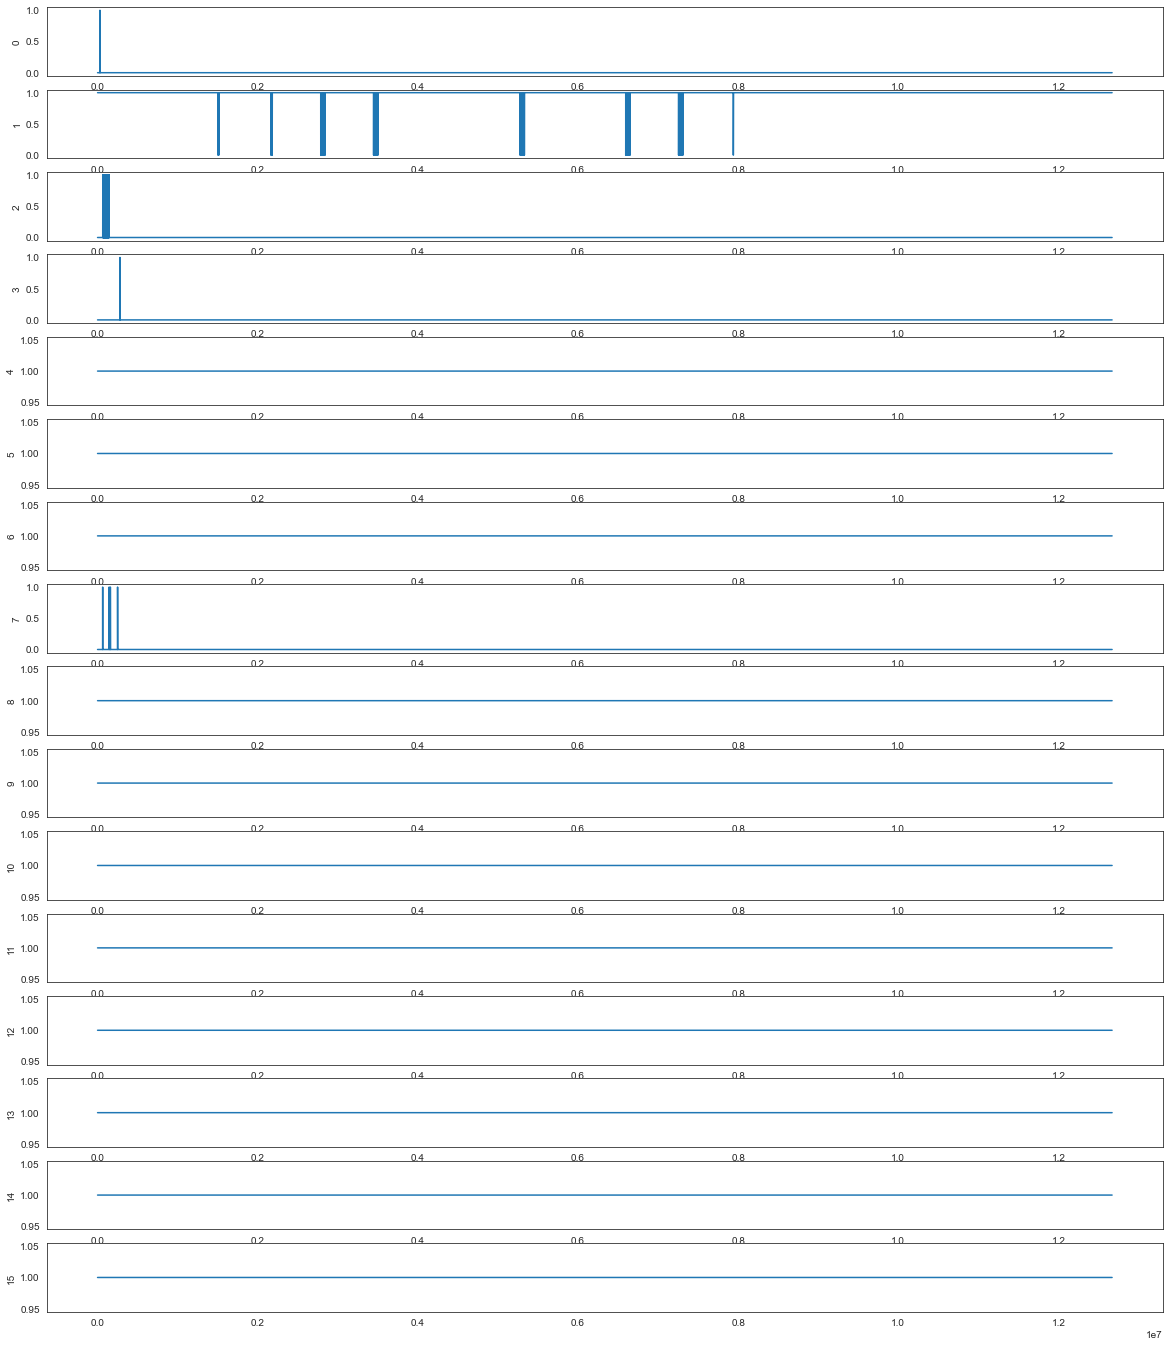

In [57]:
fig, axs = plt.subplots(16, 1, figsize=(20, 24))
for i, signal in enumerate(sync_trace):
#     axs[i].plot(signal[60000:1000000-930000])
    axs[i].plot(signal)
    axs[i].set_ylabel(i)
plt.show()

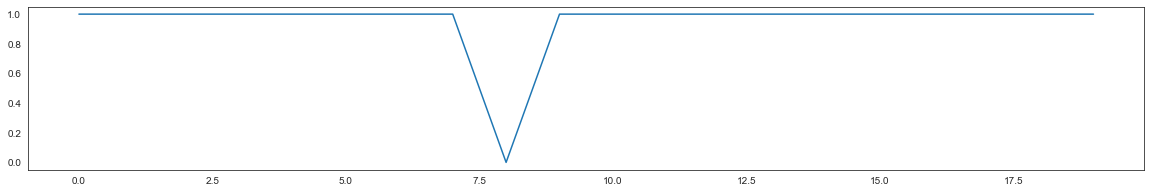

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(20, 3))
axs.plot(sync_trace[1,1503050:1503070])
plt.show()

In [11]:
from scipy.signal import medfilt
# medfilt(sync_trace[1,:], kernel_size=5)
# np.diff(np.where(np.diff(medfilt(sync_trace[1,3430000:3520000], kernel_size=3))!=0)[0])
# np.diff(np.where(np.diff(medfilt(sync_trace[1,:], kernel_size=7))!=0)[0])

In [12]:
np.where(np.diff(medfilt(sync_trace[1,:], kernel_size=7))!=0)[0]

array([2163062, 2163437, 2787065, 2787341, 2793065, 2793342, 2799065,
       2799342, 2805066, 2805341, 2811066, 2811338, 2817066, 2817337,
       2823066, 2823336, 2829066, 2829338, 2835066, 2835335, 2841066,
       2841337, 3447070, 3447368, 3453070, 3453370, 3459070, 3459368,
       3465070, 3465366, 3471070, 3471369, 3477070, 3477368, 3483070,
       3483366, 3489070, 3489368, 3495070, 3495370, 3501070, 3501366,
       5275983, 5276314, 5281983, 5282312, 5287984, 5288311, 5293984,
       5294310, 5299984, 5300310, 5305984, 5306311, 5311984, 5312311,
       5317984, 5318309, 5323984, 5324310, 5329984, 5330311, 6595992,
       6596055, 6601992, 6602055, 6607993, 6608057, 6613993, 6614057,
       6619993, 6620059, 6625993, 6626061, 6631993, 6632062, 6637993,
       6638065, 6643993, 6644069, 6649993, 6650071, 7255997, 7256280,
       7261997, 7262278, 7267997, 7268285, 7273997, 7274285, 7279997,
       7280286, 7285997, 7286288, 7291997, 7292289, 7297997, 7298291,
       7303997, 7304

In [15]:
np.diff(np.where(np.diff(medfilt(sync_trace[1,:], kernel_size=7))!=0)[0])

array([    375,  623628,     276,    5724,     277,    5723,     277,
          5724,     275,    5725,     272,    5728,     271,    5729,
           270,    5730,     272,    5728,     269,    5731,     271,
        605733,     298,    5702,     300,    5700,     298,    5702,
           296,    5704,     299,    5701,     298,    5702,     296,
          5704,     298,    5702,     300,    5700,     296, 1774617,
           331,    5669,     329,    5672,     327,    5673,     326,
          5674,     326,    5674,     327,    5673,     327,    5673,
           325,    5675,     326,    5674,     327, 1265681,      63,
          5937,      63,    5938,      64,    5936,      64,    5936,
            66,    5934,      68,    5932,      69,    5931,      72,
          5928,      76,    5924,      78,  605926,     283,    5717,
           281,    5719,     288,    5712,     288,    5712,     289,
          5711,     291,    5709,     292,    5708,     294,    5706,
           296,    5

In [46]:
(subsess_events_table & {'experiment_id': '01588', 'subsession_id': 'OPTS_0014'}).fetch1('trials')

[[2163063, 2163438],
 [2787066,
  2787342,
  2793066,
  2793343,
  2799066,
  2799343,
  2805067,
  2805341,
  2811067,
  2811339,
  2817067,
  2817338,
  2823067,
  2823337,
  2829067,
  2829339,
  2835067,
  2835336,
  2841067,
  2841338],
 [3447071,
  3447369,
  3453071,
  3453371,
  3459071,
  3459369,
  3465071,
  3465367,
  3471071,
  3471370,
  3477071,
  3477369,
  3483071,
  3483367,
  3489071,
  3489369,
  3495071,
  3495371,
  3501071,
  3501367],
 [5275984,
  5276315,
  5281984,
  5282313,
  5287985,
  5288312,
  5293985,
  5294311,
  5299985,
  5300311,
  5305985,
  5306312,
  5311985,
  5312312,
  5317985,
  5318310,
  5323985,
  5324311,
  5329985,
  5330312],
 [6595993,
  6596056,
  6601993,
  6602056,
  6607994,
  6608058,
  6613994,
  6614058,
  6619994,
  6620060,
  6625994,
  6626061,
  6631994,
  6632063,
  6637994,
  6638066,
  6643994,
  6644070,
  6649994,
  6650072],
 [7255998,
  7256281,
  7261998,
  7262279,
  7267998,
  7268286,
  7273998,
  7274286,
  72799

In [134]:
key = {'experiment_id': '01588', 'subsession_id': 'OPTS_0013'}
# key = {'experiment_id': '01231', 'subsession_id': 'OPTS_0001'}

trials = (subsess_events_table & key).fetch1('trials')
sync_trace = (raw_table & key).fetch1('sync_trace')

In [135]:
[np.diff(trial) for trial in trials]

[array([ 218, 5782,  222, 5778,  225, 5775,  228, 5772,  231, 5770,  234,
        5766,  237, 5763,  239, 5761,  240, 5760,  242], dtype=int64),
 array([  46, 5954,   47, 5953,   48, 5952,   43, 5957,   47, 5953,   47,
        5953,   49, 5951,   49, 5951,   50, 5950,   53], dtype=int64),
 array([ 185, 5815,  188, 5812,  187, 5813,  187, 5813,  190, 5811,  191,
        5809,  196, 5804,  199, 5801,  201, 5799,  203], dtype=int64)]

In [92]:
len(trials[0])

2

In [93]:
np.mean(sync_trace[1])

0.9989786962671112

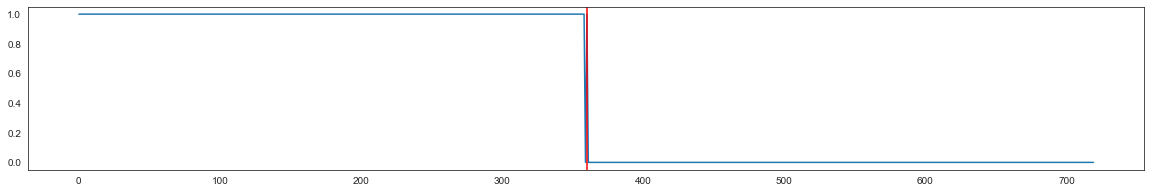

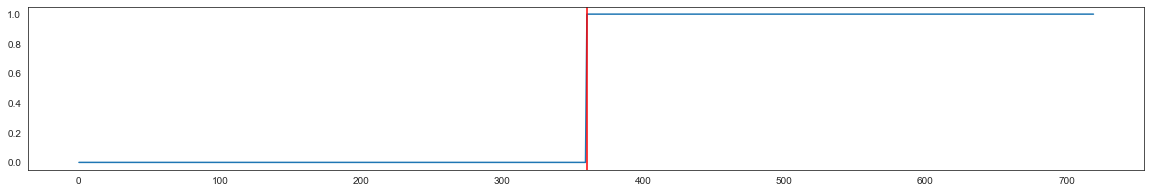

In [94]:
for trigger in trials[0]:
    fig, axs = plt.subplots(1, 1, figsize=(20, 3))
    axs.plot(sync_trace[1,trigger-360:trigger+360])
    axs.axvline(360, c='r')
    plt.show()

In [111]:
from scipy.signal import medfilt
medfilt(sync_trace[1,3430000:3520000], kernel_size=3)
np.diff(np.where(np.diff(medfilt(sync_trace[1,3430000:3520000], kernel_size=3))!=0)[0])

array([ 298, 5702,  300, 5700,  299, 5701,  296, 5704,  299, 5701,  298,
       5702,  296, 5704,  298, 5702,  300, 5700,  296], dtype=int64)

In [57]:
all_trials

[[],
 [801301,
  801303,
  807306,
  813309,
  819311,
  819313,
  825315,
  831319,
  837322,
  843324,
  849324,
  849326],
 [],
 [2121140,
  2127141,
  2133142,
  2139137,
  2145141,
  2151141,
  2157143,
  2163142,
  2163144,
  2169144],
 [2781283,
  2787286,
  2793271,
  2793285,
  2799285,
  2805288,
  2811287,
  2811291,
  2817295,
  2823298,
  2829299,
  2829301]]

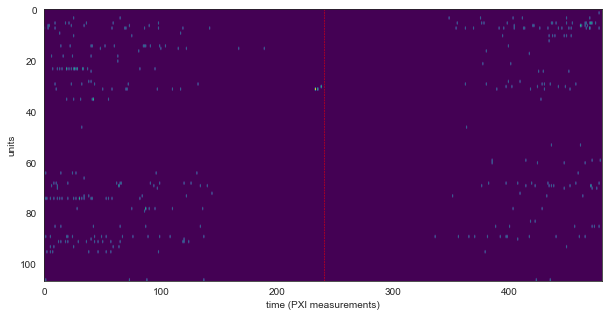

In [141]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(np.mean(spike_tensor, axis=0), aspect='auto', cmap='viridis')
# sb.heatmap(np.mean(spike_tensor, axis=0), ax=axs)
# axs.axvline(120, c='r')
# axs.axvline(150, c='r')
axs.set(xlabel='time (PXI measurements)', ylabel='units')
axs.axvline(240, c='r', linestyle='--', linewidth=0.5)
# plt.savefig(os.path.join(figures_folder, 'max_spiketensor.png'))
plt.show()

In [108]:
spike_tensor.shape

(51, 107, 480)

In [19]:
baseline_tensor = spike_tensor[:,:,:120]
baseline_mean = np.mean(baseline_tensor, axis=(2)) # (events, units)

Text(0.5, 0, 'pulses')

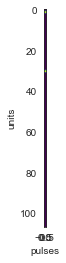

In [20]:
plt.imshow(baseline_mean.T, cmap='viridis')
plt.ylabel('units')
plt.xlabel('pulses')
# plt.savefig(os.path.join(figures_folder, 'baseline_mean.png'))

In [18]:
baseline_mean.shape

(570, 260)

In [27]:
# opto_tensor = spike_tensor[:,:,150:180] # between 1ms-2ms after pulse | (events, neurons, time)
opto_tensor = spike_tensor[:,:,0:180] # between 1ms-2ms after pulse | (events, neurons, time)


avg_spiketimes = np.zeros(shape=opto_tensor.shape[1])
std_spiketimes = np.zeros(shape=opto_tensor.shape[1])
response_probs = np.zeros(shape=opto_tensor.shape[1])
evoked_diff_baseline = np.zeros(shape=opto_tensor.shape[1])
# baseline_means = np.zeros(shape=opto_tensor.shape[1])
# evoked_means = np.zeros(shape=opto_tensor.shape[1])

for i_unit in range(opto_tensor.shape[1]):
    unit_spikes = opto_tensor[:,i_unit,:]
    unit_spiketrials, unit_spiketimes = np.where(unit_spikes>0)
    avg_spiketime = np.mean(unit_spiketimes)
    std_spiketime = np.std(unit_spiketimes)
    
    trials_with_response = np.unique(unit_spiketrials)
    response_prob = len(trials_with_response)/unit_spikes.shape[0]
    avg_spiketimes[i_unit] = avg_spiketime
    std_spiketimes[i_unit] = std_spiketime
    response_probs[i_unit] = response_prob
    
evoked_mean = np.mean(opto_tensor, axis=(2))
# baseline_mean[(baseline_mean == 0) & (evoked_mean != 0)] = 0.0000000001
# baseline_mean[(baseline_mean == 0) & (evoked_mean == 0)] = 'nan'
evoked_diff_baseline = np.mean(evoked_mean/(baseline_mean+1), axis=0)
    
# Neurons responding between 1-2ms

# Get average spike time
# np.sum(opto_tensor, axis=0)
# spike_tensor

c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


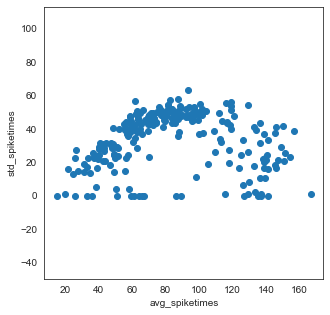

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(avg_spiketimes, std_spiketimes)
ax.axis('equal')
ax.set(xlabel='avg_spiketimes', ylabel='std_spiketimes')
plt.savefig(os.path.join(figures_folder, 'spiketimes.png'))
plt.show()

In [29]:
evoked_diff_baseline.shape

(260,)

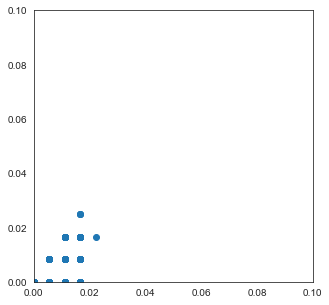

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(evoked_mean, baseline_mean)
ax.set(xlim=[0, 0.1], ylim=[0, 0.1])
plt.show()

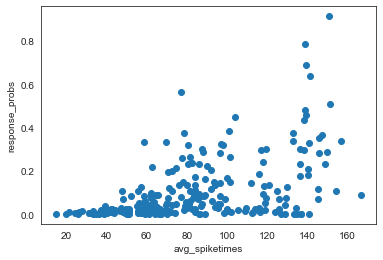

In [31]:
fig, axs = plt.subplots(1, 1)
axs.scatter(avg_spiketimes, response_probs)
axs.set_xlabel('avg_spiketimes')
axs.set_ylabel('response_probs')
plt.savefig(os.path.join(figures_folder, 'spiketimes2.png'))
plt.show()

In [40]:
opto_candidates = np.where((response_probs>0.05)&(std_spiketimes<4))[0]
# opto_candidates = np.where((std_spiketimes<1))[0]
opto_candidates = np.where((response_probs>0.05))[0]

opto_cand_spikes = opto_tensor[:,opto_candidates,:]


In [41]:
print(f"Total number of units: {len(response_probs)}, candidates remaining: {len(opto_candidates)}")

Total number of units: 260, candidates remaining: 112


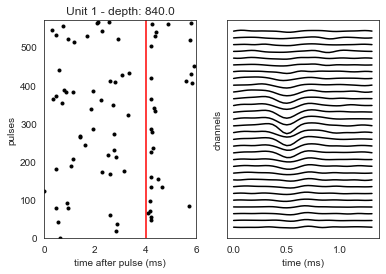

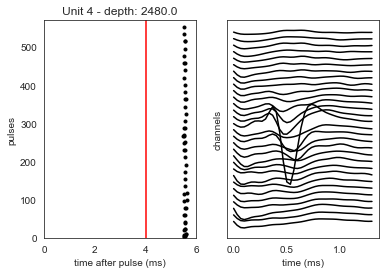

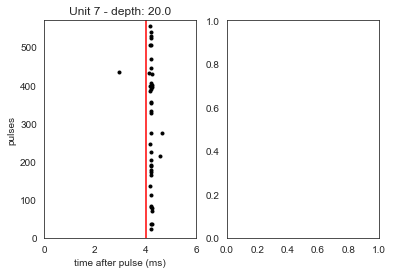

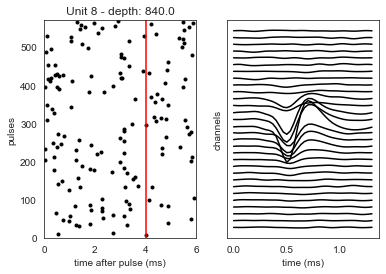

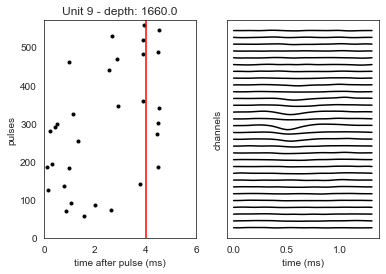

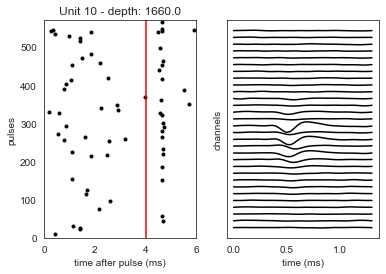

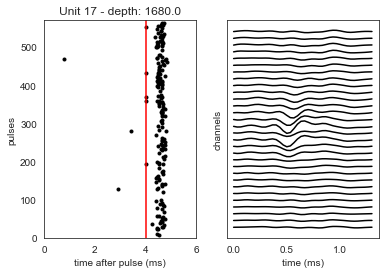

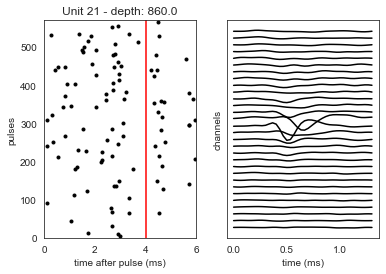

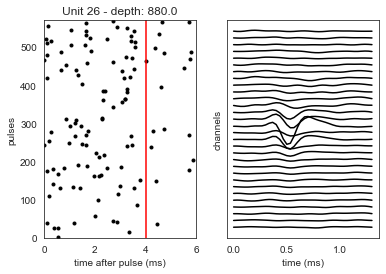

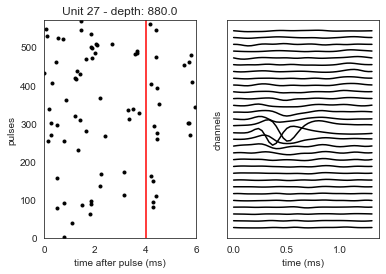

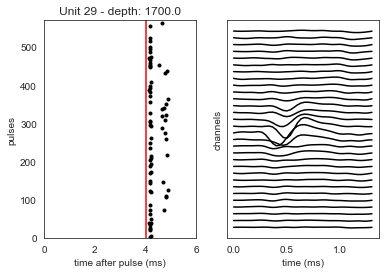

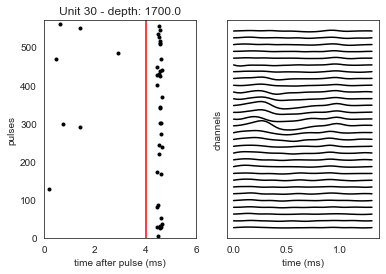

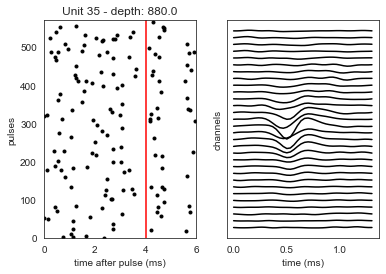

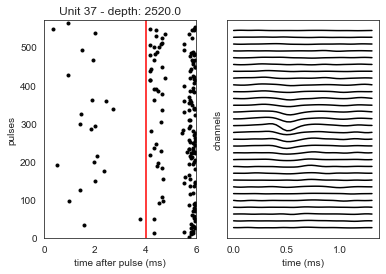

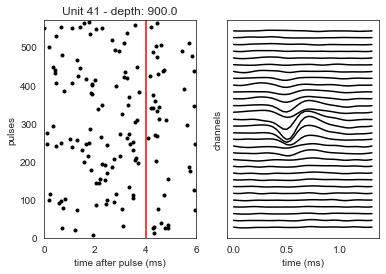

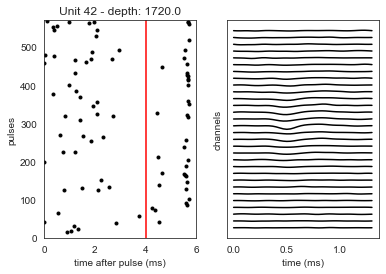

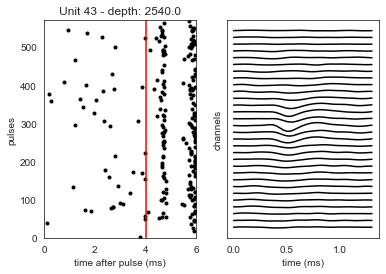

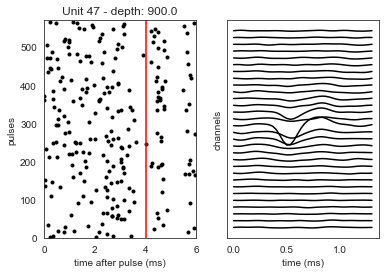

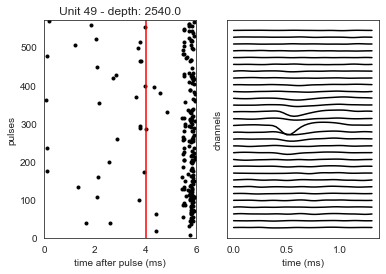

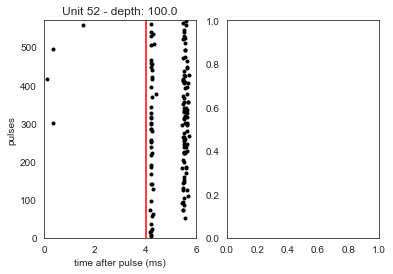

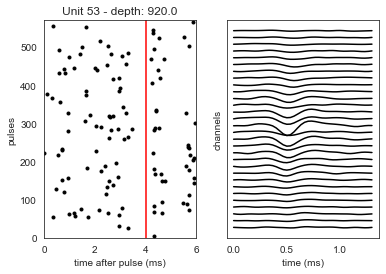

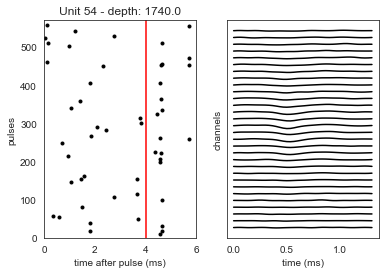

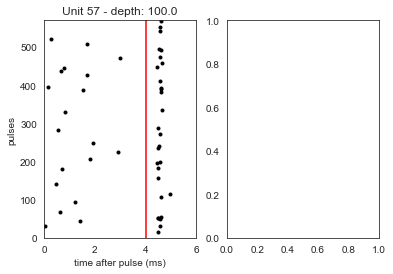

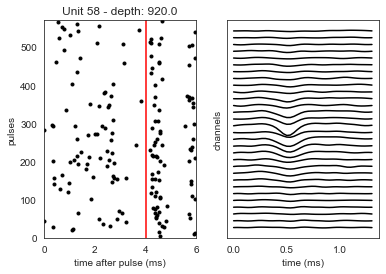

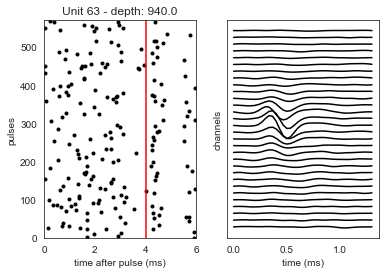

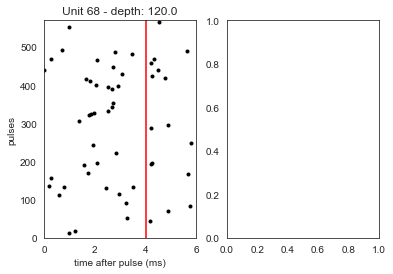

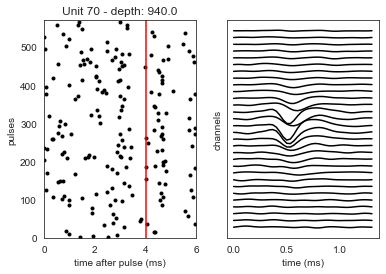

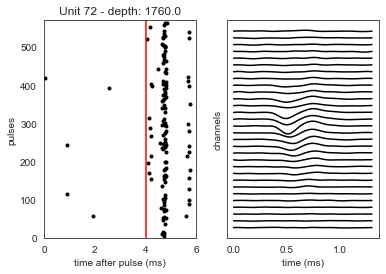

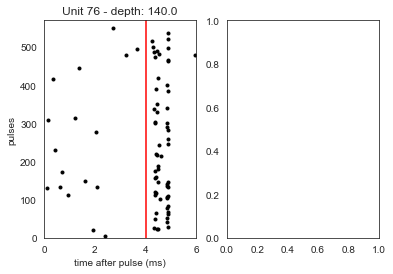

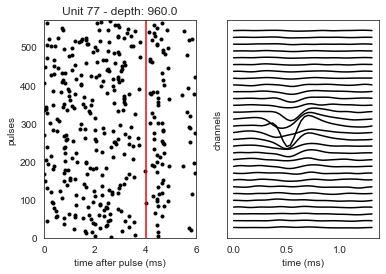

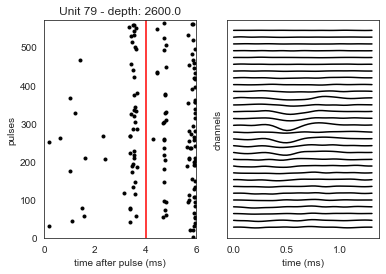

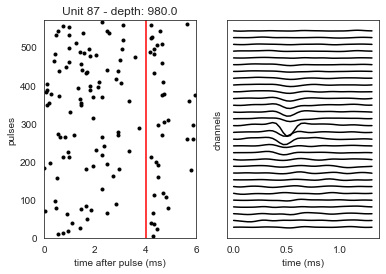

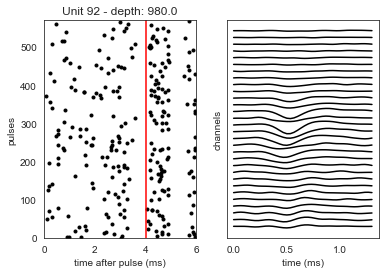

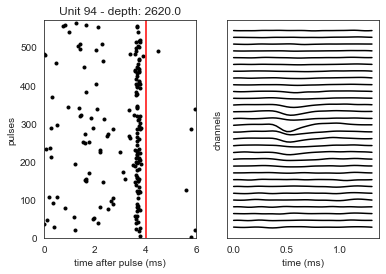

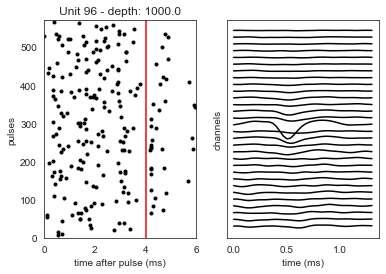

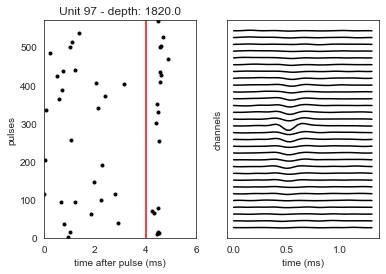

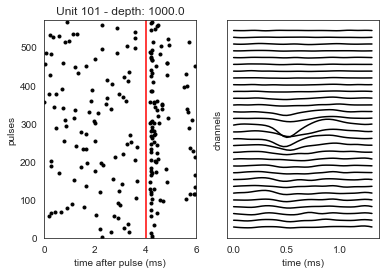

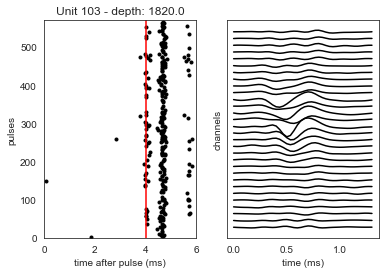

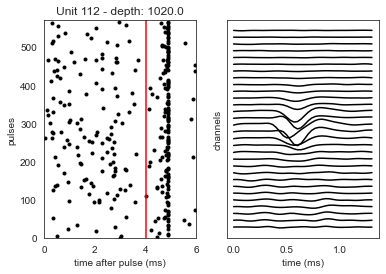

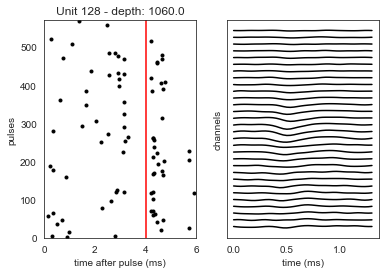

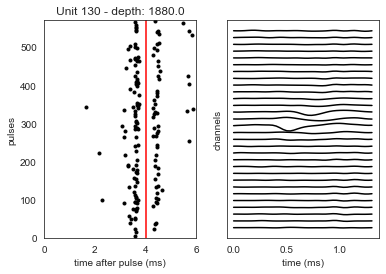

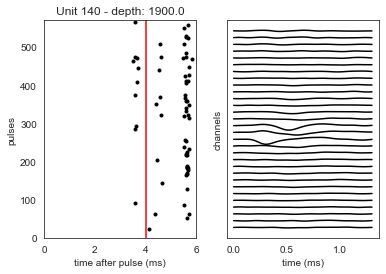

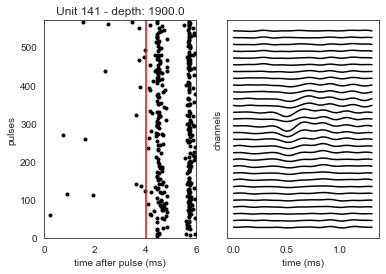

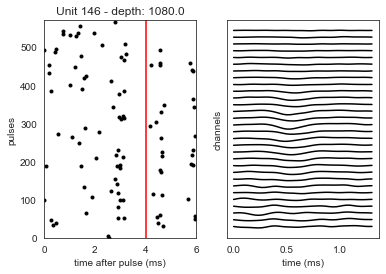

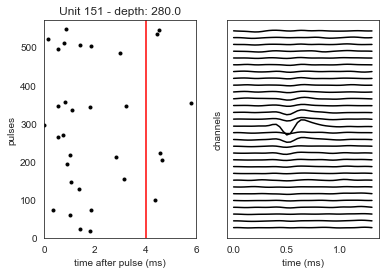

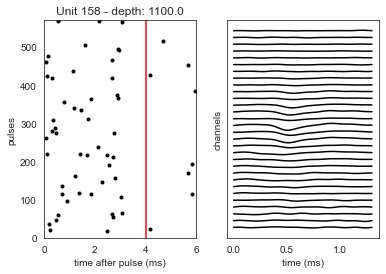

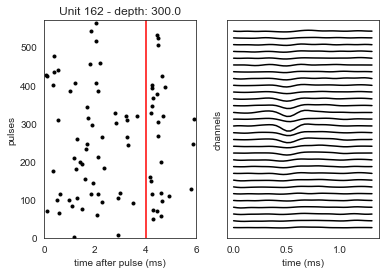

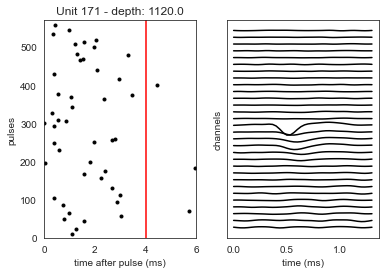

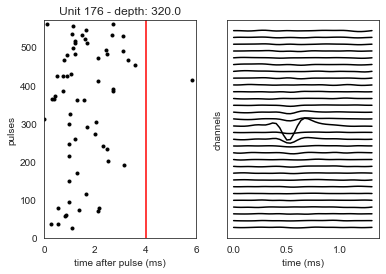

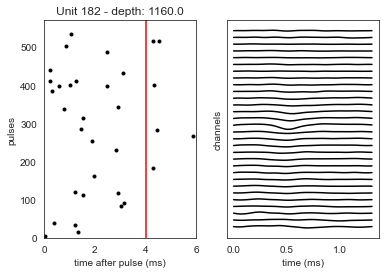

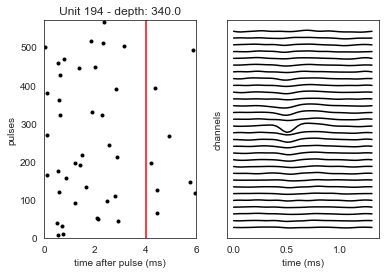

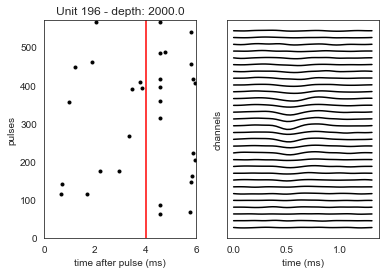

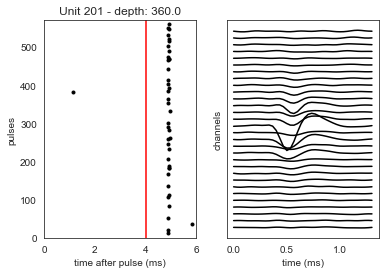

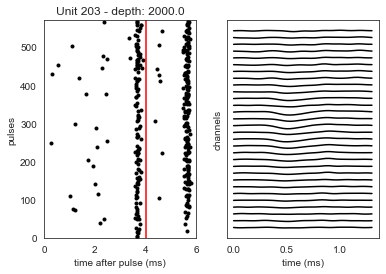

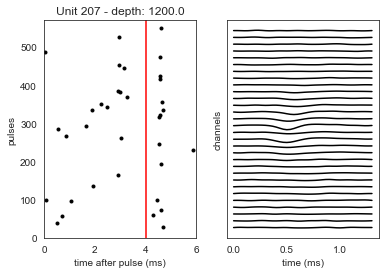

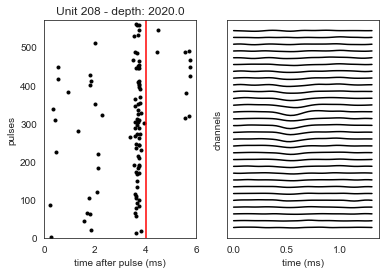

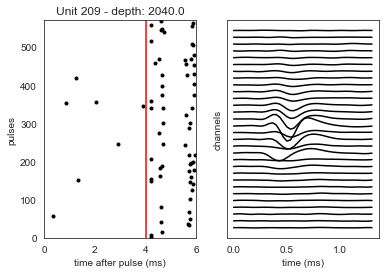

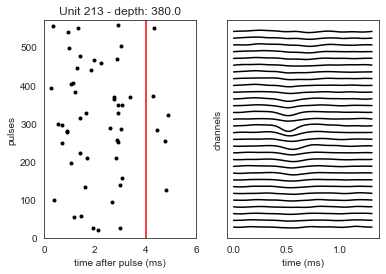

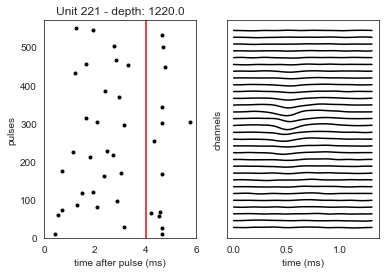

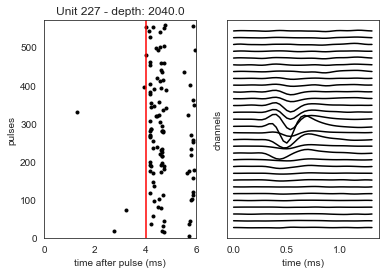

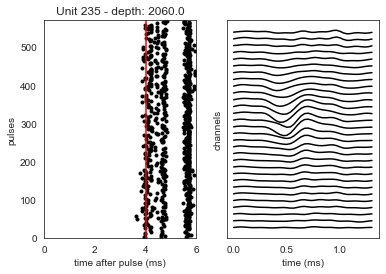

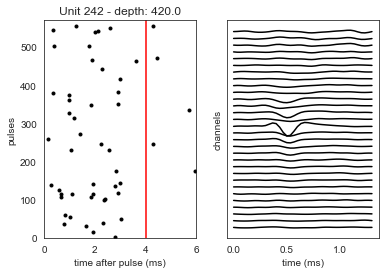

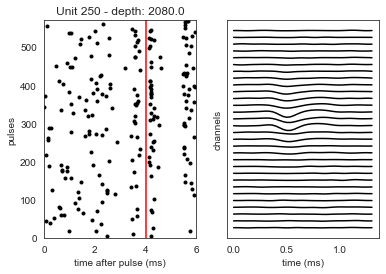

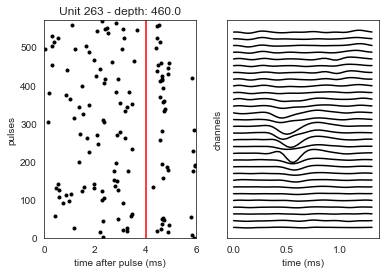

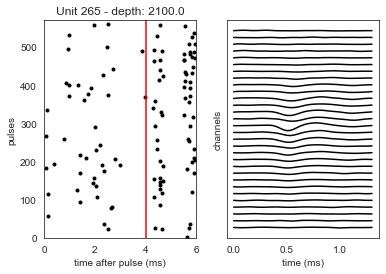

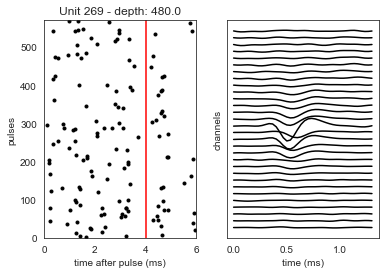

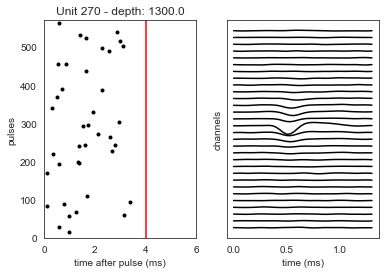

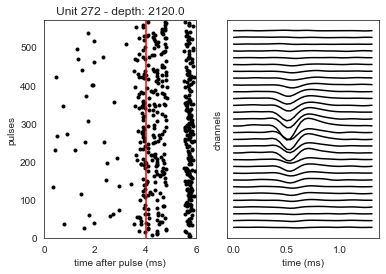

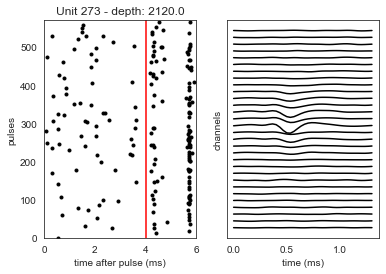

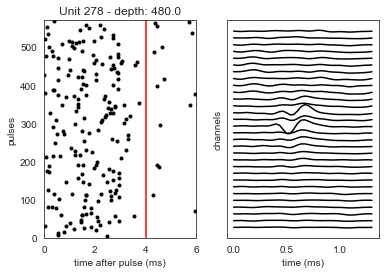

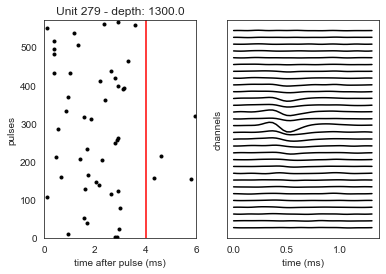

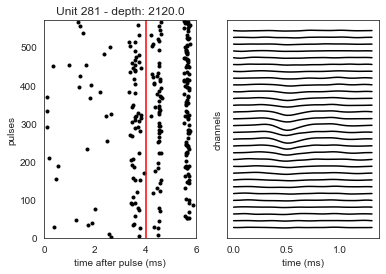

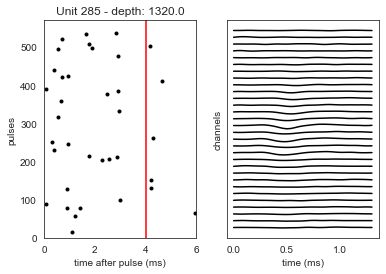

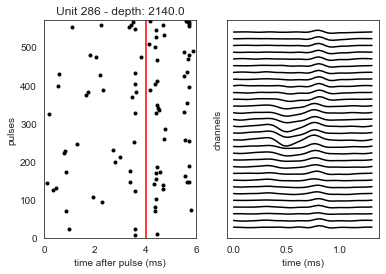

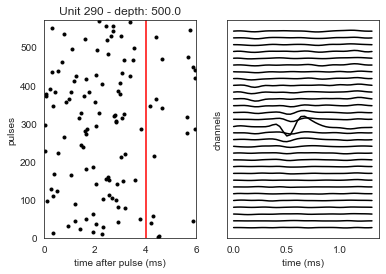

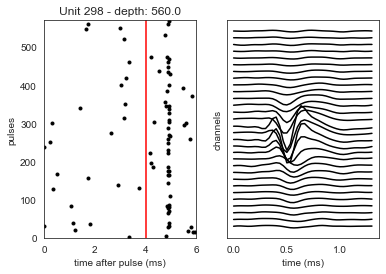

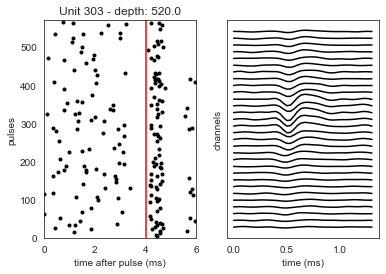

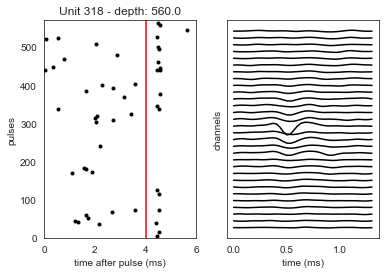

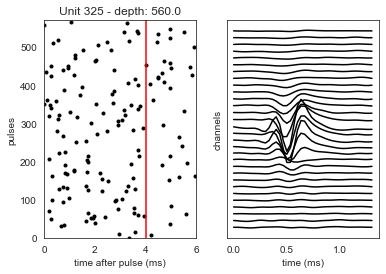

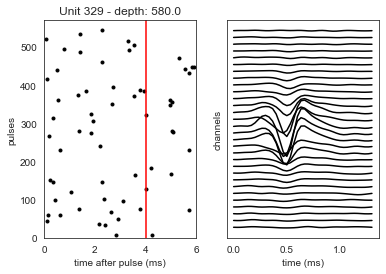

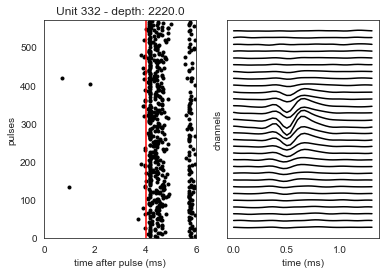

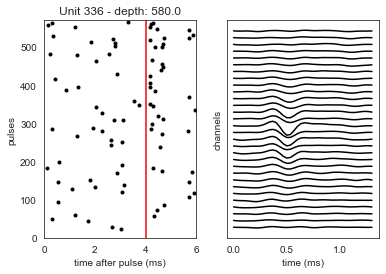

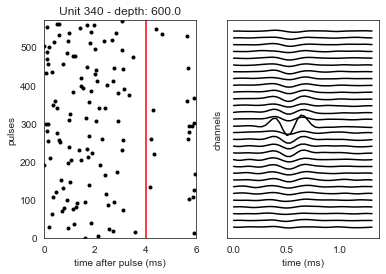

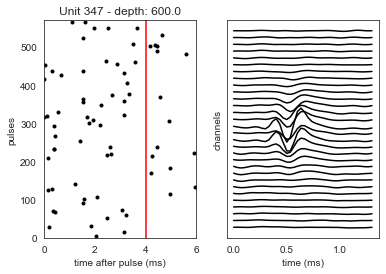

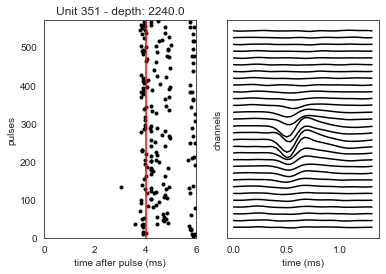

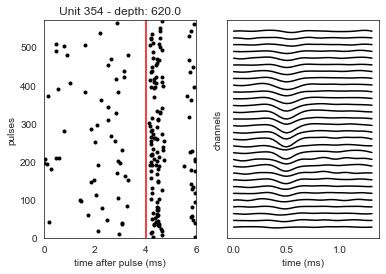

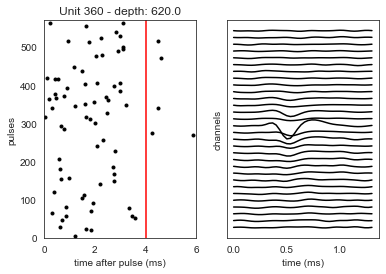

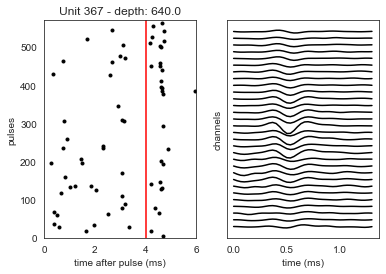

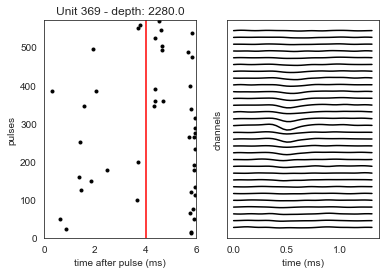

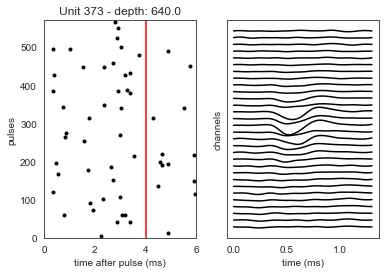

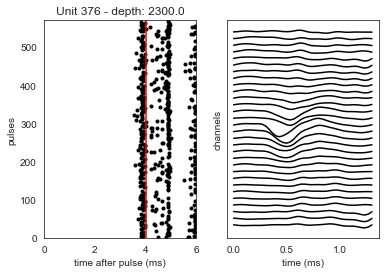

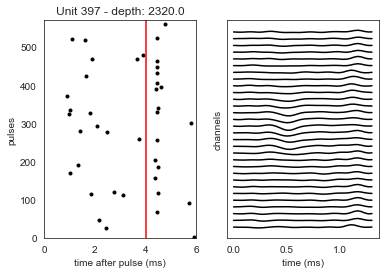

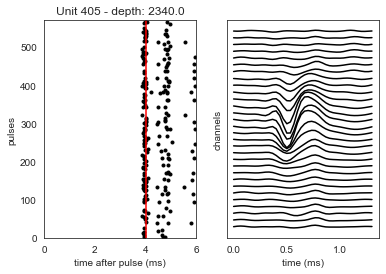

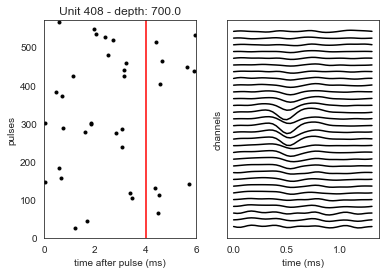

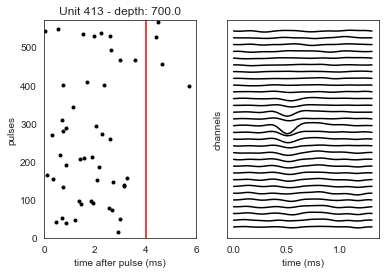

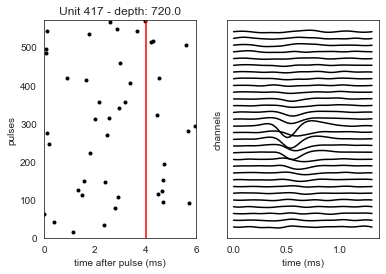

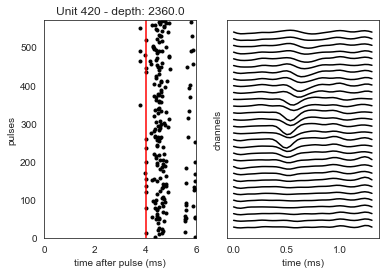

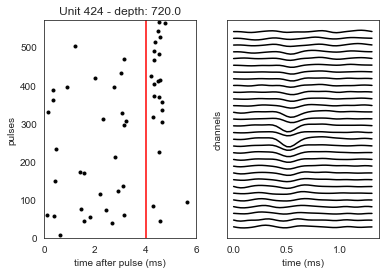

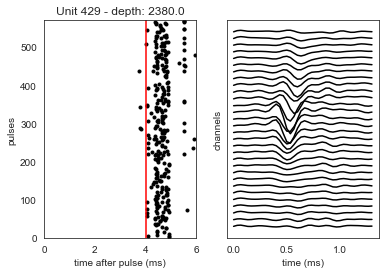

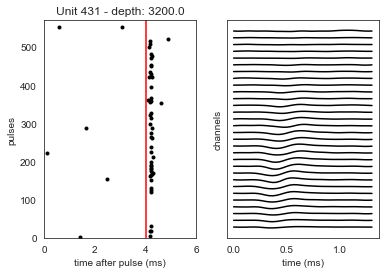

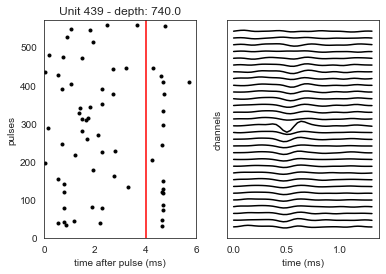

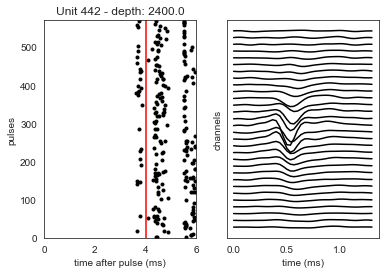

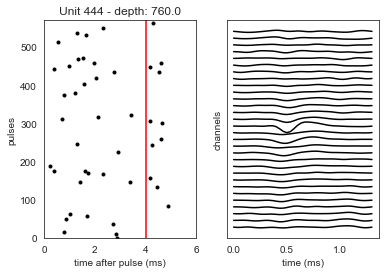

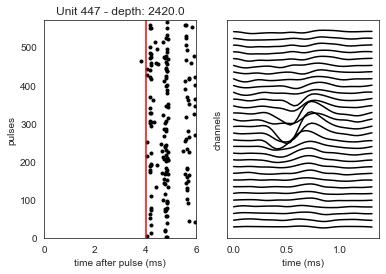

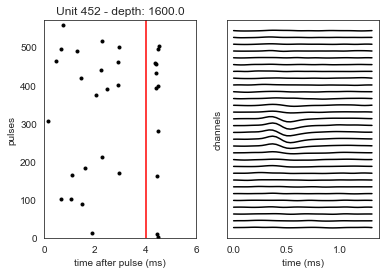

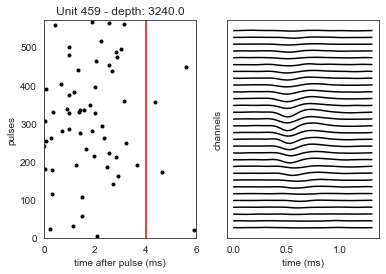

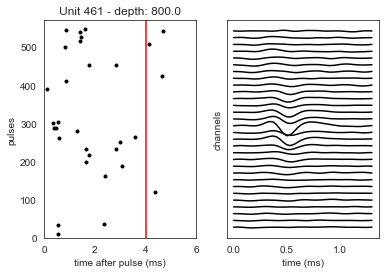

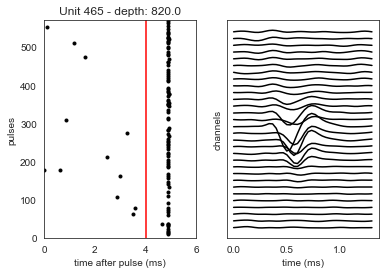

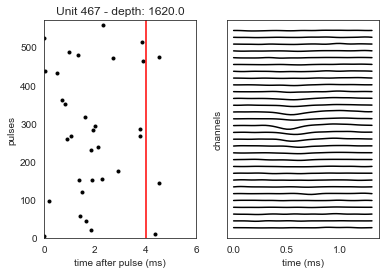

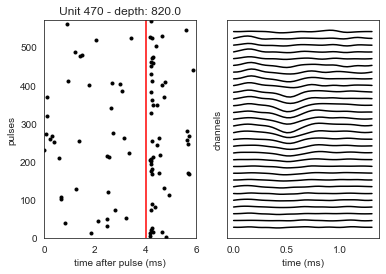

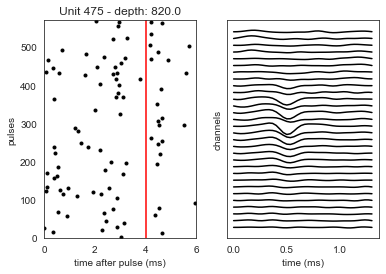

IndexError: index 499 is out of bounds for axis 0 with size 481

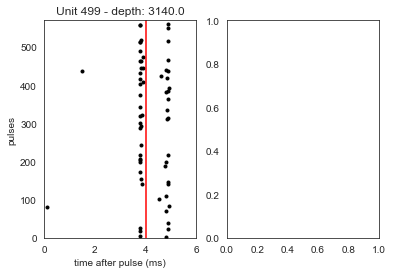

In [45]:
for i_unit in range(opto_cand_spikes.shape[1]):
    fig, axs = plt.subplots(1, 2)
    c = int(cluster_idxs[opto_candidates[i_unit]])
    c_depth = cluster_info['depth'][c]
#     axs.imshow(opto_candidates[:,i_unit,:])
    for j_trial in range(opto_cand_spikes.shape[0]):
        unit_spiketimes = np.where(opto_cand_spikes[j_trial, i_unit])[0]
        axs[0].scatter(unit_spiketimes/30, np.ones_like(unit_spiketimes)*j_trial, marker='.', c='k')
    axs[0].set_title(f"Unit {c} - depth: {c_depth}")
    axs[0].set_ylim(0, opto_cand_spikes.shape[0])
#     axs[0].set_xlim(0, 1)

    axs[0].set_xlim(0, 6)
    axs[0].axvline(4, c='r')
    
    axs[0].set(xlabel='time after pulse (ms)', ylabel='pulses')
    
    channel = cluster_info['ch'][c] # len(channel_map) - cluster_info['ch'][unit]
    n_channels = 30
    for i, row in enumerate(mean_waveforms[c,:,channel-n_channels//2:channel+n_channels//2].T): # check 203 -> nothing
    #     print("been here")
        axs[1].plot((np.arange(0, len(row)))/30, row+(i*500), 'k')
        axs[1].set(xlabel='time (ms)', ylabel='channels', yticks=[])
    
    plt.savefig(os.path.join(figures_folder, f"{c_depth}_{c}.png"))
    plt.show()

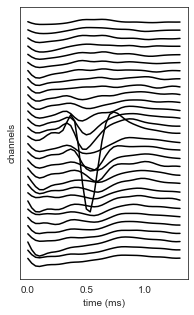

In [85]:
channel = cluster_info['ch'][4] # len(channel_map) - cluster_info['ch'][unit]
n_channels = 30

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
for i, row in enumerate(mean_waveforms[4,:,channel-n_channels//2:channel+n_channels//2].T): # check 203 -> nothing
#     print("been here")
    ax.plot((np.arange(0, len(row)))/30, row+(i*500), 'k')
    ax.set(xlabel='time (ms)', ylabel='channels', yticks=[])
# plt.savefig('mean_waveform_unit203.png', dpi=150)
plt.show()

In [12]:
def smooth_spikecounts(spikecounts, sigma=2):
    return ndimage.gaussian_filter1d(spikecounts, sigma)

def filter_clusters(clusters, cluster_annot, annot=['good']):
    clusters_filtered = {}
    for c in cluster_annot:
        if cluster_annot[c] in annot:
            clusters_filtered[c] = clusters.get(c)
    return clusters_filtered
                

def plot_spike_raster(clusters, start, end, ax, event_times=None, colored=False, color_palette=None, visualize_depth=False, cluster_depths=None):
    data = []

    for c, cl_spike_times in clusters.items():
        if cl_spike_times is not None and isinstance(cl_spike_times, np.ndarray):
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            data.append((c, cl_spike_times_sub))
            
    for i, (cluster, cl_spike_times) in enumerate(data[:]):
        if visualize_depth:
            depth = cluster_depths[cluster]
        else:
            depth = cluster
            
        if colored:
            color = color_palette[random.randint(0, len(color_palette)-1)]
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[color]) # SCATTER PLOT
        else:
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[(0, 0, 0, 0.4)]) # SCATTER PLOT
    
    ax.set_ylabel('depth')
    ax.set_xlabel('time (s)')
    if event_times is not None:
        event_types_and_times = list(zip(*[(i, t) for tup in event_times for (i, t) in enumerate(tup)]))
        event_types = np.array(event_types_and_times[0]) 
        event_times = np.array(event_types_and_times[1])
        event_times_sub = event_times[(event_times >= start) & (event_times < end)]
        event_types_sub = event_types[(event_times >= start) & (event_times < end)]
        for event in event_times_sub:
            ax.axvline(event/30000, ymin=0, ymax=1, c='r', alpha=0.8)
            
def spikes_2_spikecounts(clusters, start, end, binsize=30):
    """Excludes neurons that don't fire"""
    first_spike_time = min([s[0] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    last_spike_time = max([s[-1] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    fr_clusters = {}
    for i, (c, cl_spike_times) in enumerate(clusters.items()):
        if cl_spike_times is not None:
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            fr, _ = np.histogram(cl_spike_times_sub, bins=np.arange(start, end, (30000/1000)*binsize))
            fr_clusters[c] = np.float32(fr)
    return fr_clusters

def plot_spikecounts_mean(fr_clusters, ax, mean=True, event_times=None):
    trial_frs = []
    for j, (c, firing_rate) in enumerate(fr_clusters.items()):
#         axs[i].plot(np.ones_like(firing_rate)*c*1, firing_rate)
        trial_frs.append(firing_rate)
    ax.plot(np.mean(np.array(trial_frs), axis=0))


In [13]:
def get_spiking_tensor(session_key, stim, before=int(30000*0.1), after=0):    
    subsess_key = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
    cluster_info, clusters = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']
    
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    trial_lengths = [e-s for s, e in zip(trial_starts, trial_ends)]
    print("Trial lengths: ", trial_lengths)

    n_trials, n_neurons, window_size = len(trial_starts), len(clusters_good), int(max(trial_lengths)+before+after)  
    spiking_tensor = np.zeros(shape=(n_trials, n_neurons, window_size))
    spiking_tensor_meta = np.zeros(shape=(n_neurons))
    for trial_idx, (start, end) in enumerate(zip(trial_starts, trial_ends)):
        for c_idx, c in enumerate(clusters_good):
            c_activity = clusters.get(c, None)
            if c_activity is not None:
                spiking_activity = c_activity[(c_activity >= start-before) & (c_activity < end+after)] - start - before
#                 print(spiking_activity)
                spiking_tensor[trial_idx, c_idx, spiking_activity] = 1
            spiking_tensor_meta[c_idx] = c
    
    return spiking_tensor, spiking_tensor_meta

def get_fr_tensor(subsess_key, before=int(30000*0.1), after=0, binsize=25):
    cluster_info, clusters = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']
    
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    trial_lengths = [e-s for s, e in zip(trial_starts, trial_ends)]
    print("Trial lengths: ", trial_lengths)

    n_trials, n_neurons, window_size = len(trial_starts), len(clusters_good), int(max(trial_lengths)+before+after)  
    n_bins = int((window_size*1000)/(30000*binsize))
    fr_tensor = np.zeros(shape=(n_trials, n_neurons, n_bins))
    fr_tensor_meta = np.zeros(shape=(n_neurons))
    for trial_idx, (start, end) in enumerate(zip(trial_starts, trial_ends)):
        for c_idx, c in enumerate(clusters_good):
            c_activity = clusters.get(c, None)
            if c_activity is not None:
                spiking_activity = c_activity[(c_activity >= start-before) & (c_activity < end+after)]
                fr, _ = np.histogram(spiking_activity, bins=np.arange(start-before, end+after, (30000/1000)*binsize))
#                 print(fr)
                fr_tensor[trial_idx, c_idx, :len(fr)] = smooth_spikecounts(fr, sigma=0.5)
            fr_tensor_meta[c_idx] = c
    
    return fr_tensor, fr_tensor_meta


In [14]:
# sessions = [{'experiment_id': '01230', 'session_id': '20200326a'}, {'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}]
sessions = [{'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}, {'experiment_id': '01261', 'session_id': '20200327f'}, {'experiment_id': '01247', 'session_id': '20200328e'}]
# sessions_sSC_depths = [(1900, 2250), (2100, 2450), (2250, 2550), (2800, 3100)]

In [15]:
key = {'experiment_id': '01261', 'session_id': '20200327f', 'subsession_id': 'OPTS_0001'}

clusters, cluster_annot, cluster_info = (subsess_spikes_table & key).fetch1('clusters', 'cluster_annot', 'cluster_info')
start_abs, trials_starts, subsess_triggers = (subsess_events_table & key).fetch1('start_abs', 'trials_starts', 'subsession_triggers')

c:\users\bramn\anaconda3\envs\analysis\lib\site-packages\datajoint\connection.py:218: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


In [16]:
subsess_triggers

[array([30004], dtype=int64),
 array([  711279,   712781,   714282,   715784,   717286,   718787,
          720289,   721791,   723292,   724794,   726296,   727797,
          729299,   730801,   732302,   733804,   735306,   736807,
          738309,   739811,  1311944,  1313446,  1314947,  1316449,
         1317950,  1319452,  1320954,  1322455,  1323957,  1325459,
         1326960,  1328462,  1329964,  1331465,  1332967,  1334469,
         1335970,  1337472,  1338974,  1340475,  1912609,  1914110,
         1915612,  1917114,  1918615,  1920117,  1921619,  1923120,
         1924622,  1926124,  1927625,  1929127,  1930629,  1932130,
         1933632,  1935134,  1936635,  1938137,  1939638,  1941140,
         2513273,  2514775,  2516277,  2517778,  2519280,  2520782,
         2522283,  2523785,  2525287,  2526788,  2528290,  2529792,
         2531293,  2532795,  2534297,  2535798,  2537300,  2538802,
         2540303,  2541805,  3113938,  3115440,  3116942,  3118443,
         3119945, 

In [17]:
trials_starts

[711279,
 1311944,
 1912609,
 2513273,
 3113938,
 3714603,
 4315268,
 4915933,
 5516598,
 6117263,
 6717927,
 7318592,
 7919257,
 8519922,
 9120587,
 9721251,
 10321916,
 10922581,
 11523245,
 12123910,
 12724575,
 13325239,
 13925904,
 14526568,
 15127233,
 15727897,
 16328562,
 16929226,
 17529890,
 18130555]

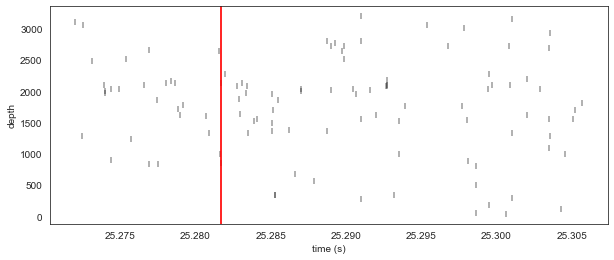

In [18]:
data = []
clusters_good = filter_clusters(clusters, cluster_annot, annot=['good'])

fig, ax = plt.subplots(figsize=(10, 4))
plot_spike_raster(clusters_good, start=758451-30000*0.01, end=758451+30000*0.025, ax=ax, event_times=[(758451, 758451)], colored=False, visualize_depth=True, cluster_depths=cluster_info['depth'])
# plt.xlim(0, 8)
# for trigger in subsess_triggers[7]:
#     ax.axvline(trigger/30000, c='r')
plt.show()